<a href="https://colab.research.google.com/github/WesleySouza13/ATIVIDADES-EXTENSIONISTAS/blob/main/ATV_EXT_WESLEY_DE_SOUZA_MATOS_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Etapa 1: Transformaçao dos dados

In [ ]:
#Base de dados
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import zipfile
#Path com arquivos
path = '/content/gdrive/MyDrive/ATV EXT - Projeto /PROJETO 3 - DETECÇÃO DE CANCER DE MAMA/archive (7).zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
#Libs usadas
from torchvision import datasets, transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [ ]:
#Objetos com arquivos das imagens
data_train = '/content/train'
data_valid = '/content/valid'

In [ ]:
# Transformações de aumento de dados
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),           # Redimensiona para 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Espelhamento horizontal
    transforms.RandomRotation(20),          # Rotação aleatória
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Ajustes de brilho e contraste
    transforms.ToTensor(),                   # Converter para tensor
])


In [ ]:
#Dataset de treino
train_dataset = datasets.ImageFolder(data_train, transform=transform_train)
train_dataset

Dataset ImageFolder
    Number of datapoints: 2372
    Root location: /content/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               ToTensor()
           )

In [ ]:
#Loader de treino
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [ ]:
#transform teste

# Pipeline de transformação para o conjunto de teste
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para tamanho fixo
    transforms.ToTensor(),         # Converter para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar (valores entre -1 e 1)
])

test_dataset = datasets.ImageFolder(data_valid, transform=test_transform)
test_dataset





Dataset ImageFolder
    Number of datapoints: 675
    Root location: /content/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)

#Etapa 2: Construçao da rede neural

In [ ]:
#Classe da Rede Neural
class ClassificadorTumores(nn.Module):
    def __init__(self):
        super(ClassificadorTumores, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),  #saída para classificação binária
            nn.Sigmoid()  #Ativação sigmoid para probabilide
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.squeeze()  #Retorna valores escalarizados





In [ ]:
model = ClassificadorTumores()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

#Etapa 3: Treinamento

In [ ]:
#Aqui envio o modelo para o CUDA do colab
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
model.to(device)

ClassificadorTumores(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

In [ ]:
#Loop de treinamento
#Setei inicialmente 5 épocas por falta de capacidade computacional
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    print(f"Época {epoch+1}/{num_epochs}")
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()

        #Zerar os gradientes
        optimizer.zero_grad()

        #Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        #Acumular a perda
        running_loss += loss.item() * inputs.size(0)

        #Monitorar progresso
        if (batch_idx + 1) % 10 == 0:
            print(f"Lote {batch_idx+1}/{len(test_loader)}, Loss: {loss.item():.4f}")

    #Perda média por época
    epoch_loss = running_loss / len(test_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Época 1/5
Lote 10/22, Loss: 1.5869
Lote 20/22, Loss: 1.0012
Epoch 1/5, Loss: 1.1961
Época 2/5
Lote 10/22, Loss: 0.7190
Lote 20/22, Loss: 0.8292
Epoch 2/5, Loss: 0.6817
Época 3/5
Lote 10/22, Loss: 0.7475
Lote 20/22, Loss: 0.4384
Epoch 3/5, Loss: 0.6149
Época 4/5
Lote 10/22, Loss: 0.5916
Lote 20/22, Loss: 0.3703
Epoch 4/5, Loss: 0.5002
Época 5/5
Lote 10/22, Loss: 0.3586
Lote 20/22, Loss: 0.4645
Epoch 5/5, Loss: 0.4899


#Etapa 4: Avaliaçao

In [ ]:
print(f"Total de imagens no conjunto de teste: {len(test_dataset)}")


Total de imagens no conjunto de teste: 675


In [ ]:
#Avaliação no conjunto de teste
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on test set: {accuracy:.4f}")


Accuracy on test set: 0.8815


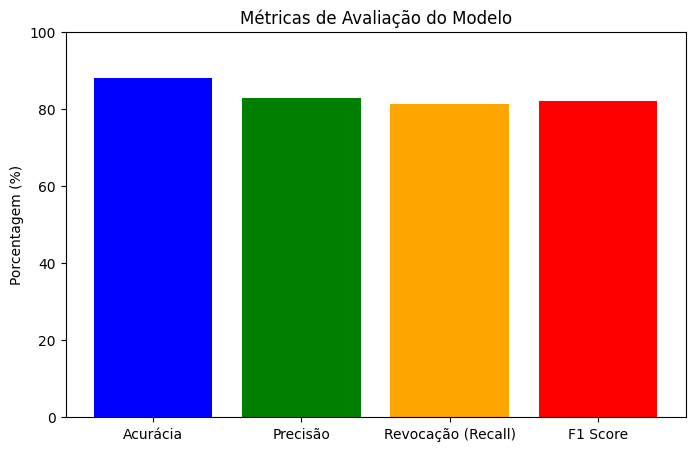

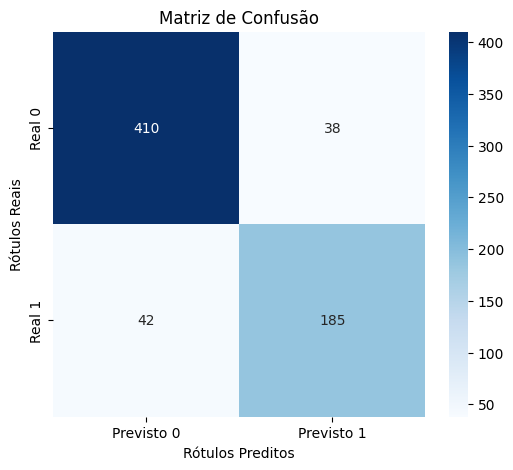

In [ ]:
# Avaliação no conjunto de teste
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Cálculo das métricas
accuracy = accuracy_score(all_labels, all_preds) * 100  # Em %
precision = precision_score(all_labels, all_preds) * 100
recall = recall_score(all_labels, all_preds) * 100
f1 = f1_score(all_labels, all_preds) * 100
conf_matrix = confusion_matrix(all_labels, all_preds)

#Plotando as métricas
metricas = {'Acurácia': accuracy, 'Precisão': precision, 'Revocação (Recall)': recall, 'F1 Score': f1}

#Gráfico das métricas
plt.figure(figsize=(8, 5))
plt.bar(metricas.keys(), metricas.values(), color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 100)
plt.title('Métricas de Avaliação do Modelo')
plt.ylabel('Porcentagem (%)')
plt.show()

#Plotando a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto 0', 'Previsto 1'], yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulos Reais')
plt.xlabel('Rótulos Preditos')
plt.show()



#Etapa 5: Teste com imagens reais

In [ ]:
def classificar_imagem_novo(caminho_completo):
    if not os.path.exists(caminho_completo):
        raise FileNotFoundError(f"Arquivo não encontrado: {caminho_completo}")

    #Carrega a imagem e converte para RGB
    imagem_teste = Image.open(caminho_completo).convert('RGB')
    plt.imshow(imagem_teste)
    plt.show()

    #Pré-processamento
    imagem_teste = imagem_teste.resize((224, 224))
    imagem_teste = np.array(imagem_teste)
    imagem_teste = imagem_teste / 255
    imagem_teste = imagem_teste.transpose(2, 0, 1)
    imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).unsqueeze(0)

    model.eval()
    imagem_teste = imagem_teste.to(device)
    with torch.no_grad():
        output = model(imagem_teste)
    print(f"Saída contínua do modelo (antes do threshold): {output}")
    output_class = (output > 0.5).float()
    print(f"Previsão (classe 0 ou 1): {output_class.item()}")
    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}
    classe_prevista = idx_to_class[int(output_class.item())]

    return classe_prevista





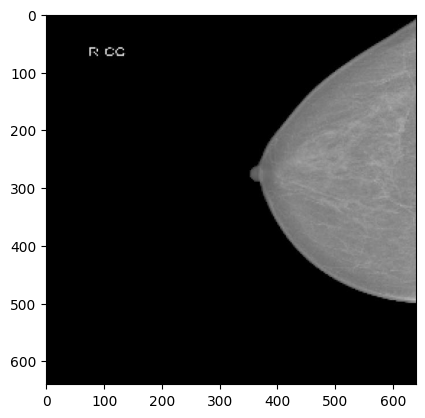

Saída contínua do modelo (antes do threshold): 0.20635554194450378
Previsão (classe 0 ou 1): 0.0


'0'

In [ ]:
classificar_imagem_novo('/teste 0.jpg')

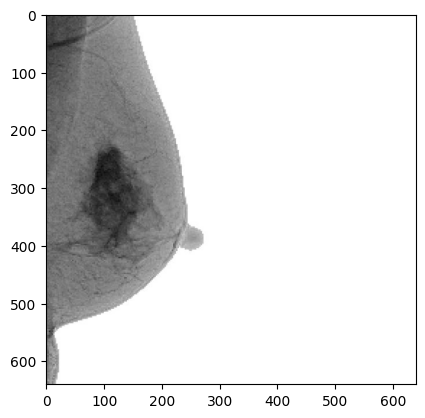

Saída contínua do modelo (antes do threshold): 0.5159831047058105
Previsão (classe 0 ou 1): 1.0


'1'

In [ ]:
classificar_imagem_novo('/1775_393941516_png.rf.fc0dfd7e90ce78f7b63e1efa98f3b0da.jpg')

#Etapa 6: Salvar modelo treinado

In [ ]:
torch.save(model.state_dict, 'modelo_final')